# MIE1628 Project 5 - B

### PhishGuard: Machine Learning-Based Detection of Phishing Websites

Description of the our project  
- Phishing websites pose a major cybersecurity threat by imitating legitimate websites to steal sensitive information such as passwords, credit card numbers, and banking credentials.  
- As online transactions and digital communications become increasingly integral to daily life, the risk associated with phishing attacks has grown substantially.  
- This project focuses on addressing this issue by developing a machine learning model that can accurately classify websites as legitimate or phishing based on a range of behavioral and structural website attributes.  
- Our preject is aim to improve browser security tools, empower users with real-time phishing detection alerts, and reduce the number of successful phishing attempts in the digital ecosystem.

### Data preprocessing

- Load the dataset and inspect its structure
- Check for data cleaning and pre-processing
- Split the data into features and target labels
- Split the dataset into training and testing sets

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import arff

In [38]:
# Data Loading
with open(r"C:\Frank\UoT 2024-2025\MIE1628\A5\website+phishing\PhishingData.arff", 'r') as f:
    data = arff.load(f)

# Convert to DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

print(df.head())
print(df.info())

  SFH popUpWidnow SSLfinal_State Request_URL URL_of_Anchor web_traffic  \
0   1          -1              1          -1            -1           1   
1  -1          -1             -1          -1            -1           0   
2   1          -1              0           0            -1           0   
3   1           0              1          -1            -1           0   
4  -1          -1              1          -1             0           0   

  URL_Length age_of_domain having_IP_Address Result  
0          1             1                 0      0  
1          1             1                 1      1  
2         -1             1                 0      1  
3          1             1                 0      0  
4         -1             1                 0      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SFH                1353 n

After loading the dataset and converting it into a DataFrame from .arff, we perform the following checks:
- Missing values
- Incorrect or inconsistent data types
- Irrelevant or redundant features
- Class imbalance

In [39]:
# Check for missing values
missing = df.isnull().sum().sum()
print("Missing values:", missing)
print(df['Result'].value_counts())

Missing values: 0
Result
-1    702
1     548
0     103
Name: count, dtype: int64


Legitimate, Suspicious and Phishy, these values have been replaced with numerical values 1,0 and -1 respectively. As the data wqas distributed uneven for phishing and legitumate class, (our target) we choose to modify the result class. By moving all suspicous class to legitumate class, it makes the dataset binary and more balanced. In the new result class, 0 = Not Phishing, 1 = Phishing

In [43]:
# Merge suspicious (0) into legitimate (1)
df['Result_new'] = df['Result'].replace({"0": 0, "1": 0, "-1": 1})

# Confirm new class distribution
print(df['Result_new'].value_counts())
print(df['Result_new'].value_counts(normalize=True) * 100)

Result_new
1    702
0    651
Name: count, dtype: int64
Result_new
1    51.884701
0    48.115299
Name: proportion, dtype: float64


C:\Users\frank\AppData\Local\Temp\ipykernel_39484\4209686227.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Result_new'] = df['Result'].replace({"0": 0, "1": 0, "-1": 1})


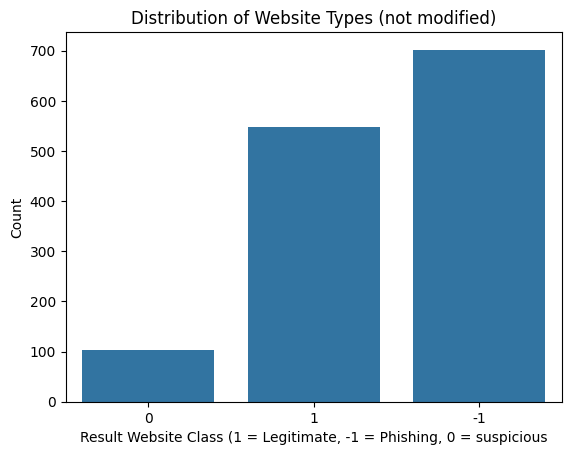

In [76]:
# Shows the number of phishing vs. sus vs. legitimate websites in your dataset.
sns.countplot(x='Result', data=df)
plt.title("Distribution of Website Types (not modified)")
plt.xlabel("Result Website Class (1 = Legitimate, -1 = Phishing, 0 = suspicious")
plt.ylabel("Count")
plt.show()

This chart displays the distribution of website classes from the raw dataset:
Phishing websites (-1) are the majority class.  
Legitimate websites (1) come second.  
Suspicious websites (0) make up a smaller portion (~7%).  
Although suspicious sites are distinct, they share more traits with legitimate sites. For simplification and consistency in binary classification, we choose to merge them.  

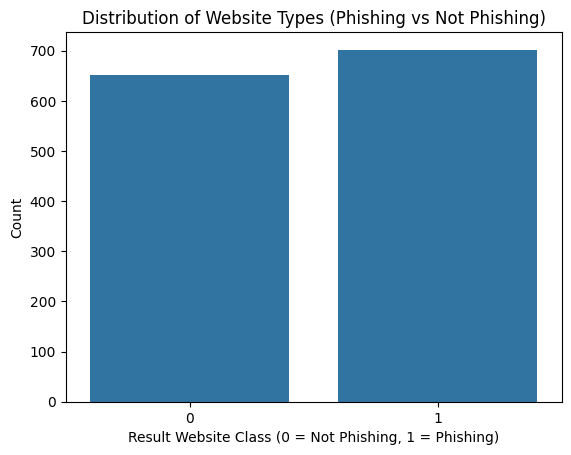

In [78]:
# Shows the number of phishing vs. legitimate websites in your dataset.
sns.countplot(x='Result_new', data=df)
plt.title("Distribution of Website Types (Phishing vs Not Phishing)")
plt.xlabel("Result Website Class (0 = Not Phishing, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

After preprocessing, we re-mapped the target variable  
Suspicious (0) merged into Legitimate (0) as negative
Phishing (-1) converted to Phishing (1) as positive  
The classes are now nearly balanced, which is ideal for most machine learning models later.  
Binary labels simplify model training and make metrics like accuracy, precision, and recall more straightforward to interpret.

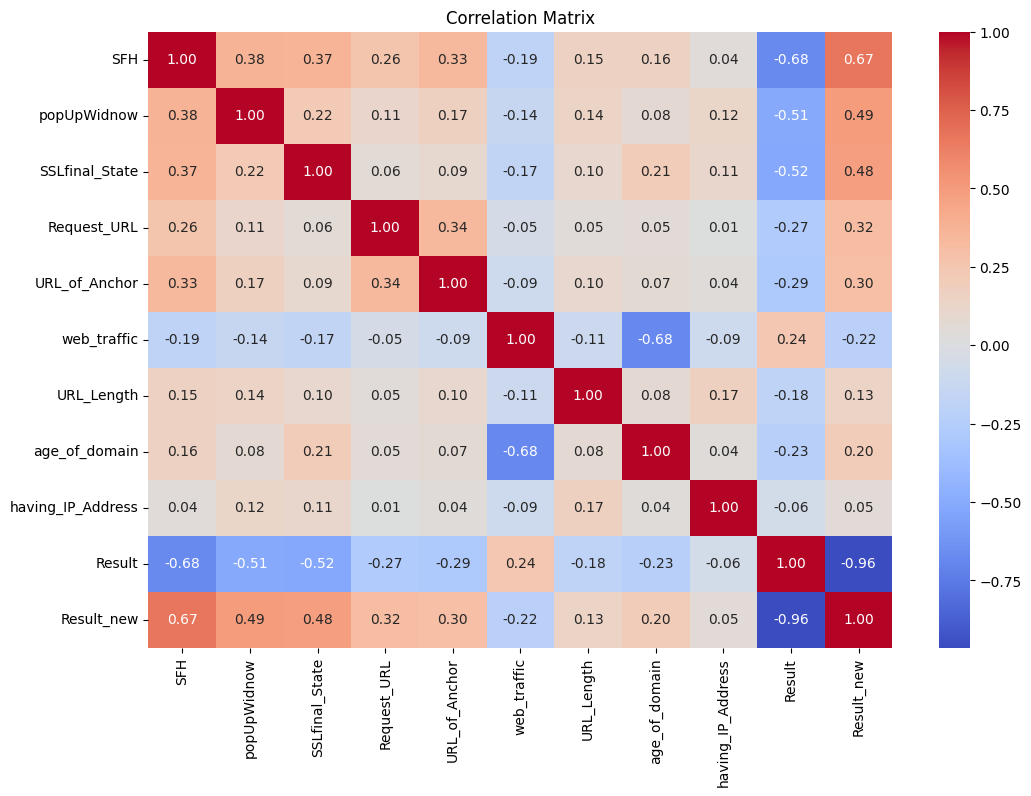

In [77]:
# Visualize how features are related to each other and to the target.
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Result vs. Result_new with correlation = -0.96 between Result and Result_new, This very strong negative correlation confirms that the modified label is an inversion of the original, due to label remapping. It validates that the transformation was applied correctly, converting a 3-class label into a binary label.  
The following features are most correlated with phishing behavior:
- SFH	+0.67	Insecure/missing form handling is highly indicative of phishing
- popUpWindow	+0.49	Use of pop-ups is strongly associated with phishing  
- SSLfinal_State	+0.48	Poor or missing SSL is a phishing red flag    
- Request_URL	+0.32	Phishing sites often use external or suspicious request URLs  
- URL_of_Anchor	+0.30	Fake/misleading anchor links appear frequently on phishing sites  

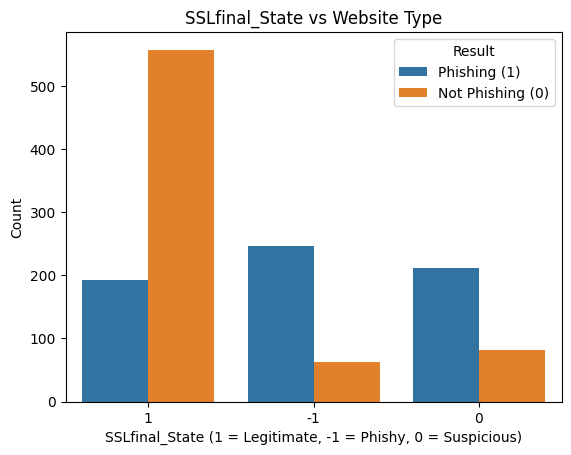

In [79]:
# SSL state is a critical security indicator.
sns.countplot(x='SSLfinal_State', hue='Result_new', data=df)
plt.title("SSLfinal_State vs Website Type")
plt.xlabel("SSLfinal_State (1 = Legitimate, -1 = Phishy, 0 = Suspicious)")
plt.ylabel("Count")
plt.legend(title="Result", labels=["Phishing (1)", "Not Phishing (0)"])
plt.show()

Websites with an SSL state of 1 (valid SSL certificate) are mostly legitimate.  
Websites with -1 (invalid/missing SSL) or 0 (suspicious certificate) are primarily phishing.  
Phishing websites frequently lack proper SSL certification, or they attempt to spoof SSL by using expired or self-signed certificates. This feature is a strong signal for phishing detection.

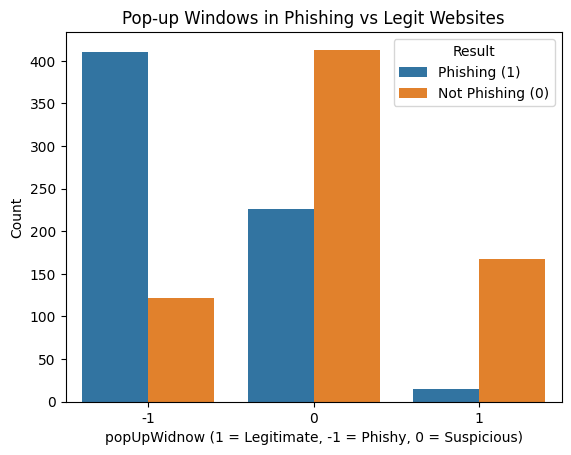

In [80]:
sns.countplot(x='popUpWidnow', hue='Result_new', data=df)
plt.title("Pop-up Windows in Phishing vs Legit Websites")
plt.xlabel("popUpWidnow (1 = Legitimate, -1 = Phishy, 0 = Suspicious)")
plt.ylabel("Count")
plt.legend(title="Result", labels=["Phishing (1)", "Not Phishing (0)"])
plt.show()

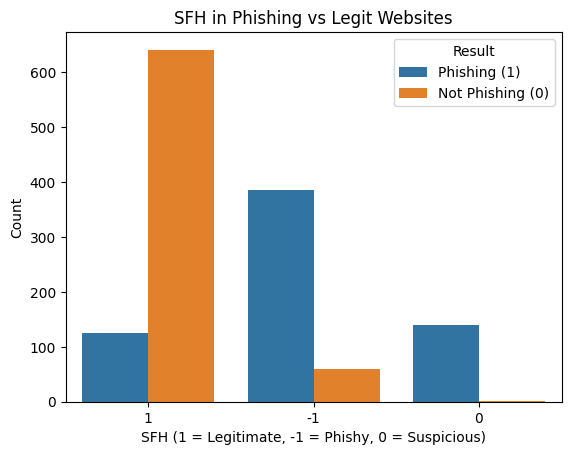

In [81]:
sns.countplot(x='SFH', hue='Result_new', data=df)
plt.title("SFH in Phishing vs Legit Websites")
plt.xlabel("SFH (1 = Legitimate, -1 = Phishy, 0 = Suspicious)")
plt.ylabel("Count")
plt.legend(title="Result", labels=["Phishing (1)", "Not Phishing (0)"])
plt.show()

when SFH = 1 (legitimate handler): Most common in legitimate websites  
when SFH = -1 (phishing handler): Strongly associated with phishing websites  
when SFH = 0 (suspicious): Primarily seen in phishing cases  
The SFH attribute indicates how form data is handled. Phishing websites often submit data to blank or external URLs, which is unusual for legitimate websites. A malformed or empty SFH field is a major phishing red flag.

In [95]:
# Split into features (X) and target labels (y)
X = df.drop('Result', axis=1)
X = X.drop('Result_new', axis =1)
X = X.apply(pd.to_numeric, errors='coerce')
y = df['Result_new']      
y = y.apply(pd.to_numeric, errors='coerce')         

In [94]:
X

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
0,1,-1,1,-1,-1,1,1,1,0
1,-1,-1,-1,-1,-1,0,1,1,1
2,1,-1,0,0,-1,0,-1,1,0
3,1,0,1,-1,-1,0,1,1,0
4,-1,-1,1,-1,0,0,-1,1,0
...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0
1349,-1,0,1,0,-1,0,0,1,0
1350,-1,0,-1,-1,-1,0,-1,-1,0
1351,0,0,1,0,0,0,-1,1,0


In [96]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1348    0
1349    1
1350    0
1351    0
1352    1
Name: Result_new, Length: 1353, dtype: int64

In [97]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=823, stratify=y)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 1082
Testing samples: 271


## Modeling

In [117]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, accuracy_score
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)

    print(f"\n {name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f" RMSE: {rmse:.4f}")
    print(f" Accuracy: {acc:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Phish", "Phish"])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


 Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       130
           1       0.88      0.87      0.87       141

    accuracy                           0.87       271
   macro avg       0.87      0.87      0.87       271
weighted avg       0.87      0.87      0.87       271

 RMSE: 0.3594
 Accuracy: 0.8708



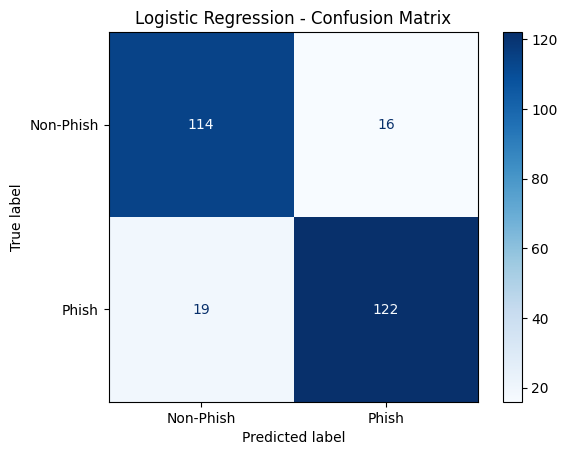

In [118]:
# Logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")



 Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       130
           1       0.92      0.86      0.89       141

    accuracy                           0.89       271
   macro avg       0.89      0.89      0.89       271
weighted avg       0.89      0.89      0.89       271

 RMSE: 0.3327
 Accuracy: 0.8893



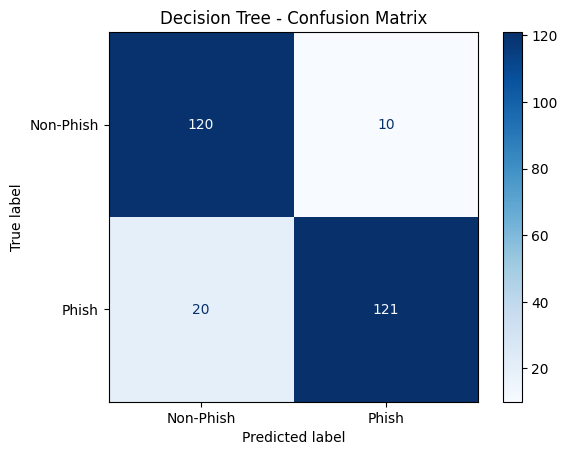

In [119]:
# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=823)
dt_model.fit(X_train, y_train)
evaluate_model(dt_model, X_test, y_test, "Decision Tree")


 Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       130
           1       0.91      0.89      0.90       141

    accuracy                           0.90       271
   macro avg       0.90      0.90      0.90       271
weighted avg       0.90      0.90      0.90       271

 RMSE: 0.3156
 Accuracy: 0.9004



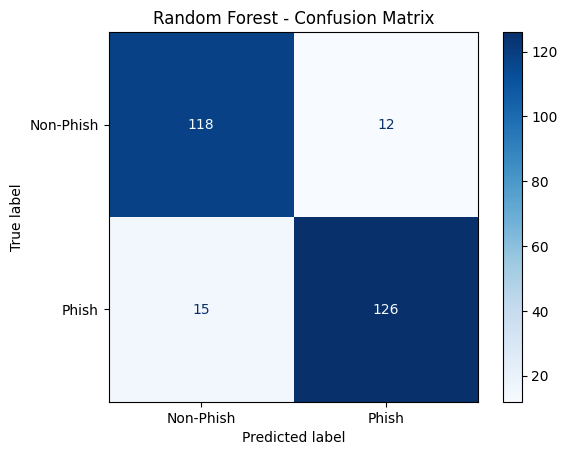

In [120]:
# Random forrest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=823)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

c:\Users\frank\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       130
           1       0.93      0.89      0.91       141

    accuracy                           0.91       271
   macro avg       0.91      0.91      0.91       271
weighted avg       0.91      0.91      0.91       271

 RMSE: 0.3037
 Accuracy: 0.9077



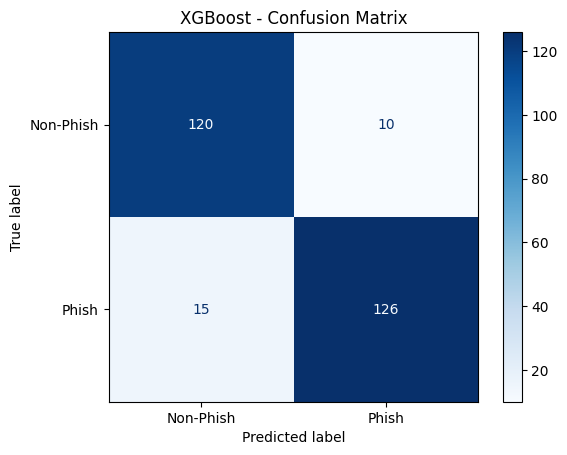

In [121]:
# xgboost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=823)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")